# Clustering via XAI

This notebook takes a kmeans-clustering algorithm and rewrites it as a 2-layer Neural Net, following Kauffmann et al. 2021 (https://arxiv.org/abs/1906.07633). Then, one can use XAI-techniques to analyse the NN. Kauffmann et al. propose Layer-Relevance-Propagation LRP (which will be implemented at a later stage in this notebook).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import *
np.random.seed(1234)

In [2]:
x = np.random.normal(0,1,100).reshape(-1,1)
y = np.random.normal(0,1,100).reshape(-1,1)
z = np.random.normal(0,1,100).reshape(-1,1)
Data = np.concatenate((x,y,z), axis=1)

x = np.random.normal(0,1,100).reshape(-1,1)
y = np.random.normal(5,1,100).reshape(-1,1)
z = np.random.normal(0,1,100).reshape(-1,1)
newDat = np.concatenate((x,y,z), axis=1)
Data = np.concatenate((Data,newDat))

x = np.random.normal(5,1,100).reshape(-1,1)
y = np.random.normal(-5,1,100).reshape(-1,1)
z = np.random.normal(0,1,100).reshape(-1,1)
newDat = np.concatenate((x,y,z), axis=1)
Data = np.concatenate((Data,newDat))

x = np.random.normal(0,1,100).reshape(-1,1)
y = np.random.normal(0,1,100).reshape(-1,1)
z = np.random.normal(5,1,100).reshape(-1,1)
newDat = np.concatenate((x,y,z), axis=1)
Data = np.concatenate((Data,newDat))

s1 = np.random.normal(0,1,400).reshape(-1,1) # superfluous data
s2 = np.random.normal(0,1,400).reshape(-1,1) # superfluous data

Data = np.concatenate((Data, s1,s2), axis =1)
np.random.shuffle(Data)
print(Data.shape)

(400, 5)


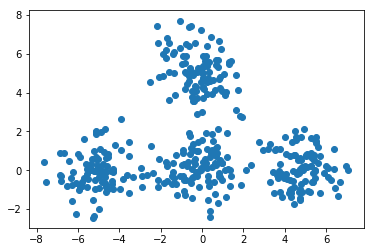

In [3]:
plt.scatter(Data[:,1], Data[:,2])

In [4]:
Data[0,:]
# should be array([ 1.38299725,  4.40664361, -0.56009295,  0.15330679,  0.03168205])

array([ 1.38299725,  4.40664361, -0.56009295,  0.15330679,  0.03168205])

In [5]:
nKM = 4
kmeans = KMeans(n_clusters=nKM, random_state=0).fit(Data)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

[[ 1.71574206e-02 -1.76319542e-01  5.06252265e+00  1.07430050e-01
   1.28495164e-01]
 [ 5.03798883e+00 -5.01356819e+00 -4.52937721e-02 -4.56142331e-03
   5.74825979e-02]
 [ 1.04955543e-01  4.80794571e+00  1.09065574e-01  1.16696186e-01
  -4.57392771e-02]
 [ 3.87275062e-02 -7.01581725e-02  1.24402617e-01  9.26459280e-02
   7.63761552e-02]]
[2 2 1 1 0 0 0 3 1 1 2 1 2 3 1 1 3 2 2 3 1 3 1 3 2 1 1 0 2 3 0 2 1 0 3 2 3
 3 3 2 1 1 2 0 3 3 3 2 1 3 1 2 0 0 3 2 1 3 1 3 1 0 3 2 0 0 3 0 1 2 0 1 0 0
 2 1 2 3 0 1 1 3 1 2 1 1 1 1 0 3 1 3 1 1 1 0 2 0 0 0 1 1 1 1 0 2 1 1 3 2 2
 2 1 1 3 1 0 3 2 2 1 2 1 1 1 3 0 0 2 0 2 0 3 2 2 3 1 3 3 2 0 1 3 0 3 2 0 2
 0 1 1 0 3 0 3 2 0 1 2 2 1 1 2 0 2 1 0 2 3 3 2 2 0 1 1 1 2 0 3 2 3 1 2 0 1
 3 3 1 1 2 1 3 0 3 3 0 3 0 3 3 3 0 3 2 1 0 0 3 0 1 1 1 3 3 3 0 3 2 0 3 2 1
 0 3 0 0 1 1 1 2 0 3 2 3 2 3 0 1 2 0 0 2 1 0 0 3 3 2 3 2 3 2 2 3 0 2 0 0 2
 3 2 0 1 1 3 2 0 0 0 1 0 1 3 2 0 1 0 0 2 1 1 3 1 2 0 2 3 1 3 0 1 2 0 1 2 0
 3 3 0 2 1 1 2 0 0 1 2 0 2 2 0 3 0 3 3 0 3 0 1 0 0 0 3 0 1 

## Neuralising K-Means

We neuralise the clustering classifier with respect to class 0, i.e. write a net that should tell us whether an instance belongs to class 0 or not.

In [6]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)
x = np.ones(Data.shape[1])
layer1(x, kmeans.cluster_centers_, 0)
    

array([  0.        ,  35.04847864,  -2.44088379, -15.8976728 ])

In [7]:
def layer2(h):
    return(min(h) >= 0)

for i in range(nKM):
    print(layer2(layer1(x, 
                   kmeans.cluster_centers_,
                   i)))

False
False
False
True


In [8]:
def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )

def DecisionLayer(Minimum):
    return(Minimum > 0)


for i in range(nKM):
    print(DecisionLayer(layer2(layer1(x, 
                   kmeans.cluster_centers_,
                   i),i)))

False
False
False
True


### Testing this 2-Layer-NN

In [9]:
X = np.random.multivariate_normal(np.ones(Data.shape[1])*2.5, 
                              np.eye(Data.shape[1]), 
                              size=1000)
Cluster_Pred = kmeans.predict(X)

In [10]:
# Now predict via the layers
Layer_Pred = np.empty(1000)



for i in range(1000):
    for j in range(nKM):
        Decision = DecisionLayer(layer2(layer1(X[i,:],
                                               kmeans.cluster_centers_,
                                               j),
                                        j))
        if Decision:
            Layer_Pred[i] = range(nKM)[j]


In [11]:
sum(Layer_Pred != Cluster_Pred)
# Very good! The numerics don't introduce any unexpected errors!

0

## Layer Relevance Propagation


In [12]:


def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [13]:
Is0 = np.empty(Data.shape[0]) # Output-array whether jth instance is assigned to cluster 0
for i in range(len(Is0)):
    Is0[i] = DecisionLayer(NN_k(Data[i,:], 
                                kmeans.cluster_centers_, 
                                0))


In [14]:
print("Should all be 0:", kmeans.labels_[Is0 == 1])
print("Should all be nonzero:",kmeans.labels_[Is0 != 1])
# Good!

Should all be 0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Should all be nonzero: [2 2 1 1 3 1 1 2 1 2 3 1 1 3 2 2 3 1 3 1 3 2 1 1 2 3 2 1 3 2 3 3 3 2 1 1 2
 3 3 3 2 1 3 1 2 3 2 1 3 1 3 1 3 2 3 1 2 1 2 1 2 3 1 1 3 1 2 1 1 1 1 3 1 3
 1 1 1 2 1 1 1 1 2 1 1 3 2 2 2 1 1 3 1 3 2 2 1 2 1 1 1 3 2 2 3 2 2 3 1 3 3
 2 1 3 3 2 2 1 1 3 3 2 1 2 2 1 1 2 2 1 2 3 3 2 2 1 1 1 2 3 2 3 1 2 1 3 3 1
 1 2 1 3 3 3 3 3 3 3 3 2 1 3 1 1 1 3 3 3 3 2 3 2 1 3 1 1 1 2 3 2 3 2 3 1 2
 2 1 3 3 2 3 2 3 2 2 3 2 2 3 2 1 1 3 2 1 1 3 2 1 2 1 1 3 1 2 2 3 1 3 1 2 1
 2 3 3 2 1 1 2 1 2 2 2 3 3 3 3 1 3 1 2 1 1 2 3 3 2 2 2 2 3 2 1 2 3 2 3 2 2
 2 3 2 1 2 2 3 3 3 3 2 2 3 3 1 3 2 3 1 1 2 1 1 3 2 2 2 2 3 1 3 3 2 1 3 3 2
 1 3 2]


In [15]:
# Beta-Heuristic from eq. (3)

Beta = np.mean(Is0)**(-1.)
print(Beta)

3.9603960396039604


In [16]:
## IMPLEMENT EQUATION (2)


#For one particular data point x
x = np.zeros(Data.shape[1])
x[0] = 4.5
x[1] = -2.


print(x) 
x_Pred = kmeans.predict(x.reshape(1, -1))[0]
print(x_Pred)

# Let's see why x was assigned to x_Pred:
n_Clust = kmeans.cluster_centers_.shape[0] # number of clusters
h_k = layer1(x, kmeans.cluster_centers_,x_Pred)
f_c = layer2(layer1(x,
                    kmeans.cluster_centers_, x_Pred), x_Pred)
print(f_c)

# numerator of equation (2)
r_k = np.exp(-Beta * h_k) *f_c
print(r_k)
print(r_k[range(n_Clust) != x_Pred])

R_k = r_k/ sum(r_k[range(n_Clust) != x_Pred])
print("R_k",R_k) # Equation (2)

[ 4.5 -2.   0.   0.   0. ]
1
14.280732523286801
[7.36822346e-68 1.42807325e+01 1.96291408e-96 3.91023298e-24]
[7.36822346e-68 1.96291408e-96 3.91023298e-24]
R_k [1.88434385e-44 3.65214365e+24 5.01994151e-73 1.00000000e+00]


In [17]:
# IMPLEMENT EQUATION (4)
m_k = 0.5*(kmeans.cluster_centers_ + kmeans.cluster_centers_[x_Pred])
print(m_k)
Diff_x_m = x - m_k
print(Diff_x_m.shape)
print(" # # # # ")
Diff_x_m_reduced = Diff_x_m[range(n_Clust) != x_Pred]
print(Diff_x_m_reduced.shape)

[[ 2.52757312e+00 -2.59494387e+00  2.50861444e+00  5.14343136e-02
   9.29888812e-02]
 [ 5.03798883e+00 -5.01356819e+00 -4.52937721e-02 -4.56142331e-03
   5.74825979e-02]
 [ 2.57147218e+00 -1.02811242e-01  3.18859008e-02  5.60673814e-02
   5.87166043e-03]
 [ 2.53835817e+00 -2.54186318e+00  3.95544227e-02  4.40422523e-02
   6.69293766e-02]]
(4, 5)
 # # # # 
(3, 5)


In [18]:
mu_c = kmeans.cluster_centers_[x_Pred]
W = 2*(mu_c - kmeans.cluster_centers_)
W_reduced = W[range(n_Clust) != x_Pred]
W_reduced.shape

R_previous_reduced = R_k[range(n_Clust)!= x_Pred] # from Equation (2)
print(R_previous_reduced)

[1.88434385e-44 5.01994151e-73 1.00000000e+00]


In [19]:
Product = np.multiply(Diff_x_m_reduced, W_reduced)
print(Product)
# Product is a Matrix P_ki with k = number of Clusters -1
#                               i = Index of the input feature
#       Shape of Product is (number Clusters -1,  number Input Features)

print(Product.shape)
print(Product[:,1])

[[ 1.98064456e+01 -5.75578284e+00  2.56270841e+01  1.15204092e-02
   1.32067582e-02]
 [ 1.90269838e+01  3.72665315e+01  9.84377357e-03  1.35971933e-02
  -1.21216760e-03]
 [ 1.96135203e+01 -5.35730378e+00  1.34244854e-02  8.56246139e-03
   2.52906801e-03]]
(3, 5)
[-5.75578284 37.26653153 -5.35730378]


In [20]:
R_input = np.zeros(Data.shape[1]) # Relevance of each input-feature

Denominator_Eq4 = np.sum(Product,1) # summing over all input features
print(Denominator_Eq4)

[39.70247404 56.31574413 14.28073252]


In [21]:
for k in range(3):
    print(np.sum(Product[k,:]))

39.70247403958452
56.31574413353557
14.280732523286806


In [22]:

for i in range(len(R_input)):
    
    for k in range(n_Clust-1):
        
        R_input[i] +=  Product[k,i] * R_previous_reduced[k] / np.sum(Product[k,:])
    
print(R_input.round(1))

[ 1.4 -0.4  0.   0.   0. ]


In [23]:
print(x, x_Pred)
print(kmeans.cluster_centers_.round(1))

[ 4.5 -2.   0.   0.   0. ] 1
[[ 0.  -0.2  5.1  0.1  0.1]
 [ 5.  -5.  -0.  -0.   0.1]
 [ 0.1  4.8  0.1  0.1 -0. ]
 [ 0.  -0.1  0.1  0.1  0.1]]


That is really interesting! There is high positive relevance attributed to x[0], which makes sense because its high value clearly guides the classifier towards cluster 1. However, there is negative relevance attributed to x[1]: its value does not correspond well with centroid_1[1]. Maybe that's why we get negative relevance?

#### Now for a different example

In [41]:
x = np.zeros(Data.shape[1])
x[1] = 4.0
x[2] = 2.0
x[3] = 1.0

In [25]:

x_Pred = kmeans.predict(x.reshape(1, -1))[0]
print(x_Pred)

## IMPLEMENT EQUATION (2)

# Let's see why x was assigned to x_Pred:
n_Clust = kmeans.cluster_centers_.shape[0] # number of clusters
h_k = layer1(x, kmeans.cluster_centers_,x_Pred)
f_c = layer2(layer1(x,
                    kmeans.cluster_centers_, x_Pred), x_Pred)
print(f_c)

# numerator of equation (2)
r_k = np.exp(-Beta * h_k) *f_c
print(r_k)
print(r_k[range(n_Clust) != x_Pred])

R_k = r_k/ sum(r_k[np.arange(n_Clust) != x_Pred])
print("R_k",R_k) # Equation (2)


# IMPLEMENT EQUATION (4)
m_k = 0.5*(kmeans.cluster_centers_ + kmeans.cluster_centers_[x_Pred])
print(m_k)
Diff_x_m = x - m_k
print(Diff_x_m.shape)
print(" # # # # ")
Diff_x_m_reduced = Diff_x_m[np.arange(n_Clust) != x_Pred]
print(Diff_x_m_reduced.shape)

mu_c = kmeans.cluster_centers_[x_Pred]
W = 2*(mu_c - kmeans.cluster_centers_)
W_reduced = W[np.arange(n_Clust) != x_Pred]
W_reduced.shape

R_previous_reduced = R_k[np.arange(n_Clust)!= x_Pred] # from Equation (2)
print(R_previous_reduced)

Product = np.multiply(Diff_x_m_reduced, W_reduced)
print(Product)
# Product is a Matrix P_ki with k = number of Clusters -1
#                               i = Index of the input feature
#       Shape of Product is (number Clusters -1,  number Input Features)

print(Product.shape)
print(Product[:,1])

R_input = np.zeros(Data.shape[1]) # Relevance of each input-feature

Denominator_Eq4 = np.sum(Product,1) # summing over all input features
print(Denominator_Eq4)

2
15.89293498983962
[2.03381844e-038 3.22179081e-183 1.58929350e+001 7.34012146e-027]
[2.03381844e-038 3.22179081e-183 7.34012146e-027]
R_k [2.77082396e-012 4.38928815e-157 2.16521417e+027 1.00000000e+000]
[[ 0.06105648  2.31581308  2.58579411  0.11206312  0.04137794]
 [ 2.57147218 -0.10281124  0.0318859   0.05606738  0.00587166]
 [ 0.10495554  4.80794571  0.10906557  0.11669619 -0.04573928]
 [ 0.07184152  2.36889377  0.1167341   0.10467106  0.01531844]]
(4, 5)
 # # # # 
(3, 5)
[2.77082396e-012 4.38928815e-157 1.00000000e+000]
[[-1.07212889e-02  1.67888686e+01  5.80341200e+00  1.64554873e-02
   1.44189258e-02]
 [ 2.53703157e+01  8.05916353e+01  6.07593610e-01  2.28918026e-01
   1.21216760e-03]
 [-9.51584626e-03  1.59134113e+01 -5.77674632e-02  4.30657845e-02
   3.74123561e-03]]
(3, 5)
[16.78886865 80.59163531 15.91341128]
[ 22.61243378 106.79967486  15.89293499]


In [26]:

for i in range(len(R_input)):
    
    for k in range(n_Clust-1):
        
        R_input[i] +=  Product[k,i] * R_previous_reduced[k] / np.sum(Product[k,:])
    
print(R_input.round(1))

[-0.  1. -0.  0.  0.]


In [27]:
print(x, x_Pred)
print(kmeans.cluster_centers_.round(1))

[0. 4. 2. 1. 0.] 2
[[ 0.  -0.2  5.1  0.1  0.1]
 [ 5.  -5.  -0.  -0.   0.1]
 [ 0.1  4.8  0.1  0.1 -0. ]
 [ 0.  -0.1  0.1  0.1  0.1]]


#### Try to modularise the LRP


In [28]:
## IMPLEMENT EQUATION (2)



def Eq2(X, Centroids, c, beta):
    # take one Data.point X, the cluster Centroids and the cluster of interest c, scaling factor beta
    # output: R_k - array as in equation (2)
    
    n_C = Centroids.shape[0]
    
    H_k = layer1(X, Centroids, c)
    F_c = layer2(H_k, c)
    
    # numerator of eq. (2)
    r_k_func = np.exp(-beta * H_k) * F_c
    
    R_k_out = r_k_func / sum(r_k_func[np.arange(n_C) != c])
    #print(range(n_C), range(n_C) != c)
    return(R_k_out)

print(Eq2(x, kmeans.cluster_centers_, x_Pred, Beta))
print(Eq2(x, kmeans.cluster_centers_, 3, Beta))


[2.77082396e-012 4.38928815e-157 2.16521417e+027 1.00000000e+000]
[1.27969972e-039 2.02718429e-184 1.00000000e+000 4.61848077e-028]


In [34]:
def Eq4(X, Centroids, c, beta):

    n_C = Centroids.shape[0]
    Index = (np.arange(n_C) != c) # index of "all clusters except c"
    
    R_previous = Eq2(X, Centroids, c, beta) # from Equation (2)
    R_previous_reduced = R_previous[Index]
    MU_c = Centroids[c]
    M_k = 0.5*(Centroids + MU_c)
    DIFF_x_m = X - M_k
    
    DIFF_x_m_reduced = DIFF_x_m[Index]
    
    W = 2*(MU_c - Centroids)
    W_reduced = W[Index]
    
    Prod = np.multiply(DIFF_x_m_reduced, W_reduced)
    
    R_InputLayer = np.zeros(len(X)) # relevance of each input-feature
    
    for i in range(len(R_input)):
        for k in range(n_C-1):
            R_InputLayer[i] += Prod[k,i] * R_previous_reduced[k] / np.sum(Prod[k,:])
    
    return(R_InputLayer)

In [35]:

# IMPLEMENT EQUATION (4)
m_k = 0.5*(kmeans.cluster_centers_ + kmeans.cluster_centers_[x_Pred])
Diff_x_m = x - m_k
Diff_x_m_reduced = Diff_x_m[np.arange(n_Clust) != x_Pred]

mu_c = kmeans.cluster_centers_[x_Pred]
W = 2*(mu_c - kmeans.cluster_centers_)
W_reduced = W[np.arange(n_Clust) != x_Pred]

R_previous_reduced = R_k[np.arange(n_Clust)!= x_Pred] # from Equation (2)

Product = np.multiply(Diff_x_m_reduced, W_reduced)
print(Product)

R_input = np.zeros(Data.shape[1]) # Relevance of each input-feature


for i in range(len(R_input)):
    
    for k in range(n_Clust-1):
        
        R_input[i] +=  Product[k,i] * R_previous_reduced[k] / np.sum(Product[k,:])
    
print(R_input)

[[-1.07212889e-02  1.67888686e+01  5.80341200e+00  1.64554873e-02
   1.44189258e-02]
 [ 2.53703157e+01  8.05916353e+01  6.07593610e-01  2.28918026e-01
   1.21216760e-03]
 [-9.51584626e-03  1.59134113e+01 -5.77674632e-02  4.30657845e-02
   3.74123561e-03]]
[-5.98746944e-04  1.00128839e+00 -3.63478887e-03  2.70974395e-03
  2.35402436e-04]


In [36]:
Eq4(x, kmeans.cluster_centers_, x_Pred, Beta)

array([-5.98746944e-04,  1.00128839e+00, -3.63478887e-03,  2.70974395e-03,
        2.35402436e-04])

#### Let's try out different cluster assignments
By varying the parameter i, we can see which features of x would influence the decision towards i, if i actually was the predicted cluster. Note that this XAI-method does not tell us which cluster has actually been selected, one has to specify this (e.g. as i=kmeans.predict(x.reshape(-1,1)

In [42]:
for i in range(kmeans.cluster_centers_.shape[0]):
    print(i, Eq4(x, kmeans.cluster_centers_, i, Beta).round(2))

0 [-0.    0.74  0.26  0.    0.  ]
1 [0.24 0.75 0.01 0.   0.  ]
2 [-0.  1. -0.  0.  0.]
3 [-0.  1. -0.  0.  0.]


#### how about x from the first example

In [45]:
x = np.zeros(Data.shape[1])
x[0] = 4.5
x[1] = -2.


for i in range(kmeans.cluster_centers_.shape[0]):
    print(i, Eq4(x, kmeans.cluster_centers_, i, Beta).round(1))

0 [ 0.5 -0.1  0.6  0.   0. ]
1 [ 1.4 -0.4  0.   0.   0. ]
2 [ 0.3  0.7  0.   0.  -0. ]
3 [ 1.4 -0.4  0.   0.   0. ]
